In [8]:
import networkx as nx 
import numpy as np
import matplotlib.pyplot as plt
import EoN
from tqdm import trange
import pandas as pd
import random
from sklearn.model_selection import train_test_split

In [ ]:
def SEIR_network(G, tau, alpha, gamma, rho, tmax):
    # Initialize states: S=0 (Susceptible), E=1 (Exposed), I=2 (Infected), R=3 (Recovered)
    for node in G.nodes():
        G.nodes[node]['state'] = 0  # Start all nodes as susceptible

    initial_infected = int(rho*len(G.nodes()))
    initial_infected_nodes = random.sample(list(G.nodes()), initial_infected)
    for node in initial_infected_nodes:
        G.nodes[node]['state'] = 2

    susceptible_count = []
    exposed_count = []
    infected_count = []
    recovered_count = []

    for day in range(tmax + 1):
        new_states = {}

        # Count current states
        susceptible = sum(1 for n in G.nodes if G.nodes[n]['state'] == 0)
        exposed = sum(1 for n in G.nodes if G.nodes[n]['state'] == 1)
        infected = sum(1 for n in G.nodes if G.nodes[n]['state'] == 2)
        recovered = sum(1 for n in G.nodes if G.nodes[n]['state'] == 3)

        susceptible_count.append(susceptible)
        exposed_count.append(exposed)
        infected_count.append(infected)
        recovered_count.append(recovered)

        for node in G.nodes():
            if G.nodes[node]['state'] == 2:
                for neighbor in G.neighbors(node):
                    if G.nodes[neighbor]['state'] == 0:
                        if random.random() < tau:
                            new_states[neighbor] = 1
                if random.random() < gamma:
                    new_states[node] = 3

            elif G.nodes[node]['state'] == 1:
                if random.random() < alpha:
                    new_states[node] = 2

        for node, new_state in new_states.items():
            G.nodes[node]['state'] = new_state

    return [index for index in range(tmax + 1)], susceptible_count, exposed_count, infected_count, recovered_count


In [ ]:
# parameters for the network

N = 10**4

G=nx.barabasi_albert_graph(N, 5)
#G = nx.complete_graph(N)
#G = nx.watts_strogatz_graph(N, 8, 0.1)
#G = nx.complete_graph(N)

tmax = 250
iterations = 50  # run 5 simulations
tau_boundaries = np.arange(0.01, 0.06, 0.01)         # transmission rate
gamma = 0.08  # recovery rate
rho_boundaries = np.arange(0.005, 0.011, 0.001)     # random fraction initially infected
alpha = 0.1 # latent period rate

seed = 0
for tau in tau_boundaries:
    for rho in rho_boundaries:
        print('---')


        #fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        #ax_beta = ax.twinx()
        for iter in range(0, iterations):
            # SEIR
            t, S, E, I, R = SEIR_network(G, tau, alpha, gamma, rho, tmax)

            S = np.array(S)
            E = np.array(E)
            I = np.array(I)
            R = np.array(R)

            #ax.plot(t, I, color = 'k', alpha=0.3)

            # compute betas values
            beta_values = []
            num_days = len(t)
            for i in range(num_days - 1):
                if S[i] > 0 and I[i] > 0:
                    beta = - (S[i + 1] - S[i]) / (S[i] * I[i])
                else:
                    beta = np.nan
                beta_values.append(beta)
            beta_values.append(np.nan)
            #ax_beta.plot(beta_values, color='lightgray', alpha=0.5)
            # store the simulation results in a dataFrame
            df_sim = pd.DataFrame({
            "S": S,
            "E": E,
            "I": I,
            "R": R,
            "Beta": beta_values
            })
            # save the results to a csv file
            output_file = f"seir_seed_{seed}.csv"
            df_sim.to_csv(f'initial data/{output_file}', index=False)
            print(seed)
            seed += 1       

print('END')

Generate csv-file with value of parameters for every seeds

In [ ]:
'''
iterations = 50  # run 5 simulations
tau_boundaries = np.arange(0.01, 0.06, 0.01)         # transmission rate
gamma = 0.08  # recovery rate
rho_boundaries = np.arange(0.005, 0.011, 0.001)     # random fraction initially infected
alpha = 0.1 # latent period rate
seed_number = 0
parameters = pd.DataFrame(columns = ['seed_number','tau', 'rho'])
for tau in tau_boundaries:
    for rho in rho_boundaries:
        for iter in range(0, iterations):
            parameters = pd.concat([parameters,pd.DataFrame({'seed_number':[seed_number],'tau':[tau],'rho':[rho]})],ignore_index=True)
            seed_number += 1 

# save the results to a csv file
parameters.to_csv('initial data/seeds_parameters.csv', index=False)
print('END')
'''

C:\Users\user\AppData\Local\Temp\ipykernel_10716\1078012058.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  parameters = pd.concat([parameters,pd.DataFrame({'seed_number':[seed_number],'tau':[tau],'rho':[rho]})],ignore_index=True)


END


Train-val-test split seeds numbers

In [9]:
df = pd.read_csv('initial data/seeds_parameters.csv')
X = df.drop(columns=['tau', 'rho'])
y = df[['tau', 'rho']]
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42, stratify=y)
y = y.loc[X_train.index]
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42, stratify=y)
X_train = X_train.sort_values(by = ['seed_number'])
X_val = X_val.sort_values(by = ['seed_number'])
X_test = X_test.sort_values(by = ['seed_number'])

Sharing the seeds on train and test and generate csv-file with value of initial and finite indexies

In [10]:
train_index = pd.DataFrame(columns = ['initial','finite'])
for i, seed_number in enumerate(X_train['seed_number'].values):
    df = pd.read_csv(f'initial data/seir_seed_{seed_number}.csv')
    train_index = pd.concat([train_index, pd.DataFrame({'initial':[seed_number],'finite':[i]})],ignore_index=True)
    df.fillna(0, inplace=True)
    df.to_csv(f'train/seir_seed_{i}.csv', index=False)
train_index.to_csv('train/train_index.csv',index=False)

val_index = pd.DataFrame(columns = ['initial','finite'])
for i, seed_number in enumerate(X_val['seed_number'].values):
    df = pd.read_csv(f'initial data/seir_seed_{seed_number}.csv')
    val_index = pd.concat([val_index, pd.DataFrame({'initial':[seed_number],'finite':[i]})],ignore_index=True)
    df.fillna(0, inplace=True)
    df.to_csv(f'val/seir_seed_{i}.csv', index=False)
val_index.to_csv('val/val_index.csv',index=False)

test_index = pd.DataFrame(columns = ['initial','finite'])
for i, seed_number in enumerate(X_test['seed_number'].values):
    df = pd.read_csv(f'initial data/seir_seed_{seed_number}.csv')
    test_index = pd.concat([test_index, pd.DataFrame({'initial':[seed_number],'finite':[i]})],ignore_index=True)
    df.fillna(0, inplace=True)
    df.to_csv(f'test/seir_seed_{i}.csv', index=False)
test_index.to_csv('test/test_index.csv',index=False)

Generate csv-file with median Beta values

In [11]:
betas = []
for i in range(960):
    df = pd.read_csv(f'train/seir_seed_{i}.csv')
    betas.append(df['Beta'].values)
betas = np.array(betas)
medians = np.median(betas, axis=0)
medians_df = pd.DataFrame(medians, columns=['median_beta'])
medians_df.to_csv('train/median_beta.csv', index=False)


Research of Infected values for every seed

In [12]:
days = []

for i in range(960):
    df = pd.read_csv(f'train/seir_seed_{i}.csv')
    # find the first day, when I become zero
    zero_day = df[df['I'] == 0].index.min()

    if pd.isna(zero_day):
        days.append(0)
    else:
        days.append(zero_day)

# list of days for every seeds, when I become zero
print("Days, when I become zero for every seed:", days)

average_day = np.mean(days)
print("Mean day, when I become zero:", average_day)
count_zeros = days.count(0)
print("Count of zeros in list days:", count_zeros)

Days, when I become zero for every seed: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.int64(244), 0, np.int64(243), 0, 0, np.int64(249), np.int64(245), np.int64(233), np.int64(248), np.int64(230), 0, 0, 0, np.int64(235), np.int64(244), 0, 0, 0, 0, 0, np.int64(239), 0, np.int64(215), 0, 0, 0, 0, 0, 0, 0, np.int64(247), np.int64(250), 0, np.int64(238), 0, np.int64(246), np.int64(232), 0, 0, 0, np.int64(248), np.int64(250), 0, np.int64(238), 0, 0, 0, 0, 0

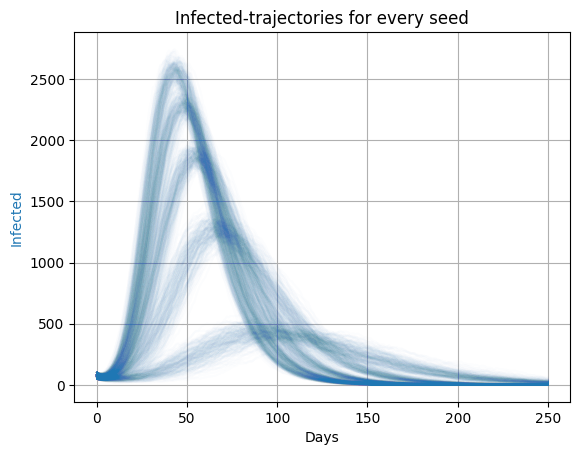

In [13]:
for i in np.arange(0,960):
    df = pd.read_csv(f'train/seir_seed_{i}.csv')
    plt.plot(np.arange(0,251), df['I'].values, alpha=0.01, color = 'tab:blue')
plt.xlabel('Days')
plt.ylabel('Infected', color='tab:blue')
plt.title('Infected-trajectories for every seed')
#plt.ylim([0,500])
plt.grid()
plt.show()

